In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import math
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [62]:
from helpers import load_data, preprocess_data

path_dataset = "/Users/chiara/Documents/EPFL/Master/Ma1/MachineLearning/project2/data/data_train.csv"
ratings = load_data(path_dataset)


number of items: 10000, number of users: 1000


### Plot the number of ratings per movie and user

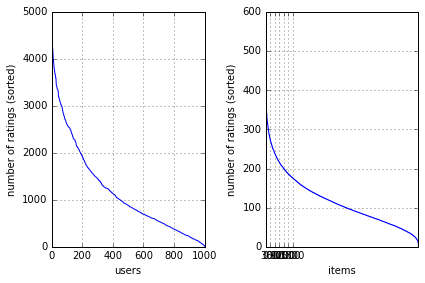

min # of items per user = 8, min # of users per item = 3.


In [63]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [64]:
import math

def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    I, J, V = sp.find(valid_ratings)
    
    all_indices = np.arange(I.shape[0])
    test_size = math.ceil(I.shape[0]*p_test)
    np.random.shuffle(all_indices)
    test_indices = all_indices[:test_size]
    train_indices = np.delete(all_indices, test_indices, axis=0)

    I_train = I[train_indices]
    J_train = J[train_indices]
    V_train = V[train_indices]
    
    I_test = I[test_indices]
    J_test = J[test_indices]
    V_test = V[test_indices]
    
    test = sp.lil_matrix(sp.coo_matrix((V_test, (I_test, J_test)), (valid_ratings.shape)))
    train = sp.lil_matrix(sp.coo_matrix((V_train, (I_train, J_train)), (valid_ratings.shape)))
    
    '''print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    '''
    return valid_ratings, train, test

In [65]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
#plot_train_test_data(train, test)

## Learn MF

#### Initialize matrix factorization

In [66]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    
    number_items, number_users = train.shape
    
    user_features = np.random.random((num_features,number_users)) #shape K*N
    item_features = np.random.random((num_features,number_items)) #shape K*D
    
    return user_features, item_features 


Compute the cost by the method of matrix factorization.


In [67]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""  
    # calculate rmse (we only consider nonzero entries.)
    prediction = item_features.transpose() @ user_features
    error = 0
    
    for d,n in nz:
        error += np.power(data[d,n]- prediction[d,n],2)
    
    return error /2 / len(nz)  

In [68]:
def prediction(W, Z):
    return(W.transpose() @ Z)

In [113]:
def matrix_factorization_SGD(train, test, num_features, lmbda_user, lmbda_item):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_epochs = 20     # number of full passes through the train set
    train_errors = []
    test_errors =[]
    
    # set seed
    np.random.seed(988)

    # init matrix
    #user_features, item_features = init_MF(train, num_features)
    Z, W = init_MF(train, num_features)
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            e = train[d,n] - prediction(W[:,d], Z[:,n])
            Z[:,n] += gamma *(e * W[:,d] - lmbda_user * Z[:,n]) 
            W[:,d] += gamma *(e * Z[:,n] - lmbda_item * W[:,d])
        
        print("iter: {}".format(it))

    train_rmse = np.sqrt(compute_error(train, Z, W, nz_train))
    test_rmse = np.sqrt(compute_error(test, Z, W, nz_test))
        #train_errors.append(train_rmse)
        #test_errors.append(test_rmse)
        #print("iter: {}, RMSE on training set: {}.".format(it, train_rmse))
        #print("RMSE on test data: {}.".format(test_rmse))
    #return test_errors, train_errors
    return test_rmse, train_rmse

#test_errors, train_errors = matrix_factorization_SGD(train, test, lmbda_user=0, lmbda_item=0)   

## Cross validation / parameter selection

### CV for lambdas

In [70]:
def cross_validation_lambdas(kfold, lambdas_user= np.array([0.1]), lambdas_item = np.array([0.1])):
    
    loss_tr = np.zeros((kfold, len(lambdas_user), len(lambdas_item)))
    loss_te = np.zeros((kfold, len(lambdas_user), len(lambdas_item)))
    num_features = 20

    # different split for every fold
    for k in range(kfold):
        valid_ratings, train, test = split_data(
            ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
        print("fold {k}:".format(k=k))
        
        for idx_user, lambda_user in enumerate(lambdas_user):
            for idx_item, lambda_item in enumerate(lambdas_item):

                loss_te[k, idx_user, idx_item], loss_tr[k, idx_user, idx_item] = matrix_factorization_SGD(train, 
                                                                                                          test, 
                                                                                                          num_features,
                                                                                                          lmbda_user, 
                                                                                                          lmbda_item) 
        
    #train_errors, test_errors = np.mean(loss_tr, axis =0), np.mean(loss_te, axis = 0)
    
    return loss_tr, loss_te

In [90]:
kfold = 1

loss_tr, loss_te = cross_validation(kfold, lambdas_item = np.logspace(-5, 1, 7))

fold 0:
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
ite

In [93]:
train_errors, test_errors = np.mean(loss_tr, axis =0), np.mean(loss_te, axis = 0)
min_idx = np.argmin(train_errors)
dev = np.std(loss_tr[:,0,min_idx], axis = 0) # std deviation over the folds



In [91]:
np.save('train_e_lufixed', loss_tr)
np.save('test_e_lufixed', loss_te)

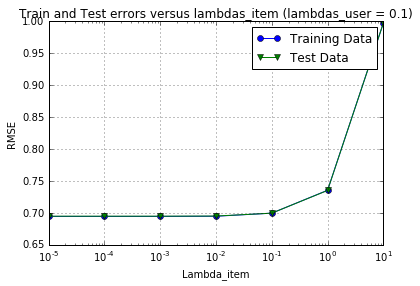

In [108]:
import matplotlib.pyplot as plt

plt.plot(lambdas, train_errors.flatten(), marker='o', label='Training Data');
plt.plot(lambdas, test_errors.flatten(), marker='v', label='Test Data');
plt.title('Train and Test errors versus lambdas_item (lambdas_user = 0.1)')
plt.xlabel('Lambda_item');
plt.ylabel('RMSE');
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()
plt.savefig('e_vs_lambdas_item')

### CV for num_features

In [110]:
def cross_validation_numfeatures(kfold, K, lambda_user= 0, lambda_item = 0):
    
    #K is the array of num_features
    
    loss_tr = np.zeros((kfold, len(K)))
    loss_te = np.zeros((kfold, len(K)))


    # different split for every fold
    for k in range(kfold):
        valid_ratings, train, test = split_data(
            ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
        print("fold {k}:".format(k=k))
        
        for idx, num_features in enumerate(K):
                loss_te[k, idx], loss_tr[k, idx] = matrix_factorization_SGD(train, test, num_features, lambda_user, 
                                                                            lambda_item)         
    #train_errors, test_errors = np.mean(loss_tr, axis =0), np.mean(loss_te, axis = 0)
    
    return loss_tr, loss_te

In [114]:
K = np.array([20, 25, 30, 35, 40, 45, 50])
kfold = 1
loss_tr, loss_te = cross_validation_numfeatures(kfold, K, lambda_user= 0, lambda_item = 0)

fold 0:
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
learn the matrix factorization using SGD...
iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
ite

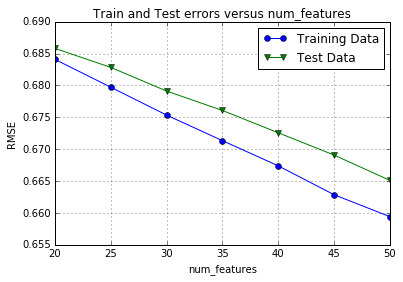

In [115]:
# save and plot
np.save('train_e_numfeatures', loss_tr)
np.save('test_e_numfeatures', loss_te)
train_errors, test_errors = np.mean(loss_tr, axis =0), np.mean(loss_te, axis = 0)


plt.plot(K, train_errors.flatten(), marker='o', label='Training Data');
plt.plot(K, test_errors.flatten(), marker='v', label='Test Data');
plt.title('Train and Test errors versus num_features')
plt.xlabel('num_features');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()
plt.savefig('e_vs_numfeatures')

## learning curve

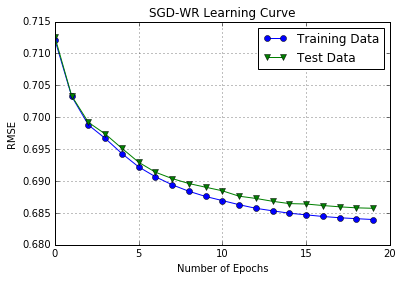

In [51]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt

plt.plot(range(20), train_errors, marker='o', label='Training Data');
plt.plot(range(20), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

## Documentation

SGD without regularization (gamma = 0.01, num_features = 20, num_epochs = 20):
    train RMSE = 0.68396
    test RMSE  = 0.68573
    
    
cross_validiation/ model selection:
1) fix lambda_user = 0.1
   lambdas_item = {0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10}
   saved in 'train_e_lufixed.npy' / 'e_vs_lambdas_item.png'
   
2) fix lambda_item = 
   lambdas_user = {0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10}
   
3) fix both lambdas to 0.001
   number features K = {20, 25, 30, 35, 40, 45, 50}
   saved in 'e_vs_numfeatures' / 'train_e_numfeatures'